## Fixed Income Factor Models Review

Models under consideration:

1. Momentum Factor 
2. Value Factor
3. Low Volatility Factor
4. VIX based Fixed Income Dynamic Allocation Model

*All models are rebalanced on month end

In [2]:
#nbi:hide_in
import warnings
warnings.filterwarnings("ignore")

In [98]:
#nbi:hide_in
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
import edhec_risk_kit_206 as erk1
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
from datetime import date
from pandas_datareader import data
import pandas_datareader.data as web
import quantstats as qs
import fixed_income_factors as fif
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#nbi:hide_in
import quandl
quandl.ApiConfig.api_key = 'KZ69tzkHfXscfQ1qcJ5K'

## Raw Data Gathering
1. Bond Total Return Indices
2. Effective Yields of Bond Indices
3. Inflation Expectations


|Fixed Income Total Return Data|
|:--|
|**US Treasuries**|
|Bloomberg Barclays US Treasuries Total Return Index (1-3Y Maturity)|
|Bloomberg Barclays US Treasuries Total Return Index (Intermediate Term)|
|Bloomberg Barclays US Treasuries Total Return Index (7-10Y Maturity)|
|Bloomberg Barclays US Treasuries Total Return Index (Long Term 20Y+)|
|**Investment Grade**|
|[ICE BofA 1-3 Year US Corporate Index Total Return Index](https://fred.stlouisfed.org/series/BAMLCC2A035YTRIV)| 
|[ICE BofA 3-5 Year US Corporate Index Total Return Index](https://fred.stlouisfed.org/series/BAMLCC2A035YTRIV) |
|[ICE BofA 7-10 Year US Corporate Index Total Return Index](https://fred.stlouisfed.org/series/BAMLCC4A0710YTRIV) |
|**High Yield**|
|[ICE BofA US High Yield Bond Index](https://fred.stlouisfed.org/series/BAMLHYH0A0HYM2TRIV)|
|[ICE BofA Crossover Emerging Markets Corporate Plus Index Total Return Index (includes only securities rated BBB1 through BB3)](https://fred.stlouisfed.org/series/BAMLEMCBPITRIV?cid=32413)|
|Bloomberg Barclays Emerging Market High Yield Total Return Index (Unhedged USD)|
|Bloomberg Barclays Pan European High Yield Bond Index (EUR index converted to USD)|

## Plot of Daily Fixed Income Total Return Indices & Real Yields

Real Yields are calculated by reducing the inflation expectations from the index yields.

Data Source: [Cleveland Fed Inflation Expectations](https://www.clevelandfed.org/our-research/indicators-and-data/inflation-expectations.aspx)

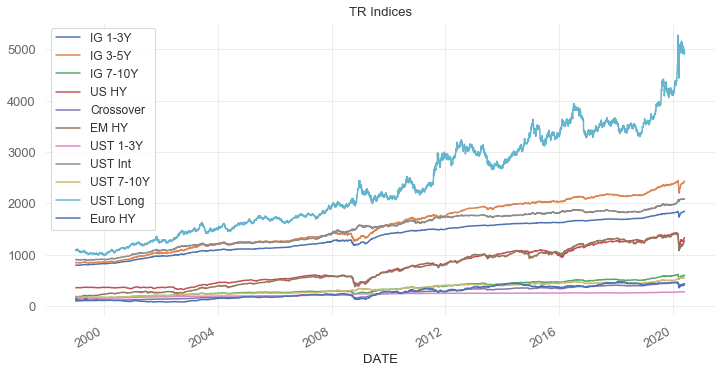

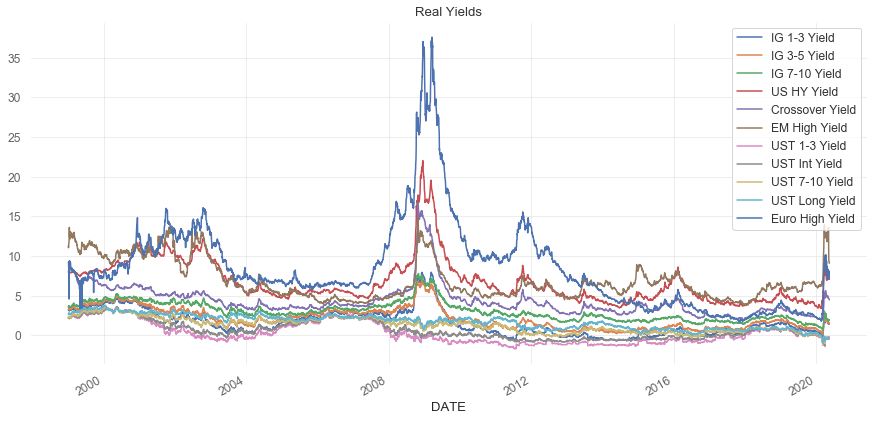

In [8]:
#nbi:hide_in
real_yields = fif.import_data()

### Defining the Function for Fixed Income Factors Backtest

1. Requires Real Yields of All Securities & Total Return Indices of the same as Raw Data
2. Input Parameters
   
   > Number of Top Scoring Securities to go buy (Max Top 3, weighted equally)
   
   > Sample Period Start Date & End Date
   
   > "Yes" for Long/Short and "No" for Long Only Backtest Results for input variable 'Long/Short'
   
3. Specific to Momentum Factor
   
   > Lookback Period for Momentum in Total Return Bond Indices (in Days) 

4. Specific to Value Factor
   
   > Lookback Period for Real Yields Z-Score Calculation (in Years)
   
   > Lookback Period for Smoothening Z-Score (in Days) to avoid timing luck factor
  
5. Specific to Low Volatility Factor
    
    > Lookback Period for Yield Volatility Calculation

6. VIX High Yield and Duration Allocation Model:

    > Lookback Period for calculating today's VIX as a percentage of the lookback period's maximum VIX value on a rolling basis
    
    > Smoothening Period i.e. a moving average of the VIX percentile for avoiding luck factor

## Generating Portfolio Tearsheet to compare with a benchmark i.e. Equally Weighted of all the above securities

In [9]:
#nbi:hide_in
import fixed_income_factors as fif
#Inputs

zscore_lookback = 7       #Number of Years
z_score_smoothening=500   #Number of Days
n_securities=3            #Number of Securities for Long only or Long/Short Portfolio
long_short='No'          #Long/Short or Long/Only as Output
duration_adj = 'Yes'
sample_start='2003'       #Start of Sample Period
sample_end='2015'         #End of Sample Period

#Momentum
lookback_period = 63     #Quarterly Returns as lookback 

## Momentum Factor Summary Statistics

> Goes long the top securities with highest total return based on the lookback period selected. 

### Interactive Momentum Factor Backtest

In [10]:
#nbi:hide_in
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)
momentum_factor  = fif.momentum_factor_backtest(indices, lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end)

In [30]:
#nbi:hide_in
def momentum_interactive(lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end):
    indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
    indices.dropna(inplace=True)
    momentum_factor  = fif.momentum_factor_backtest(indices, lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end)
    fif.plot_chart(momentum_factor[['EW', 'US HY', 'Momentum Factor', 'EM HY']], sample_start=sample_start, sample_end=sample_end, long_short=long_short, factor_name = 'Momentum')
    return erk.summary_stats1(momentum_factor,0,252).sort_values('Total Return').T

def momentum_interact():
    style = {'description_width': 'initial'}    
    return interact(momentum_interactive,lookback_period = widgets.IntSlider(63, 21, 252, 1, style=style, description='Lookback Period (Days)'),
                         duration_adj = widgets.Dropdown(options = ['Yes', 'No'], value = 'Yes',style=style, description='Duration Adjustment'), 
                         n_securities = widgets.IntSlider(3,1,3,1, style=style, description='No. of Securities'),
                         long_short= widgets.Dropdown(options = ['Yes', 'No'], value = 'No',style=style, description='Long/Short'), 
                         sample_start = widgets.DatePicker(value=pd.to_datetime('01-Jan-2003'),style=style, description = 'Sample Start'),
                         sample_end = widgets.DatePicker(value=pd.to_datetime('31-Dec-2015'),style=style,  description = 'Sample End'))


momentum_interact();

interactive(children=(IntSlider(value=63, description='Lookback Period (Days)', max=252, min=21, style=SliderS…

In [28]:
#nbi:hide_in
#qs.reports.html(momentum_factor['Momentum Strategy'], momentum_factor['EW'], output='Momentum.html', title='Momentum Factor Tearsheet')
#import webbrowser
#new = 2
#url = "Momentum.html"
#webbrowser.open(url,new=new)

## Value Factor Summary Statistics

> Go long the top securities which have the highest Z-Score of Real Yields when compared to the past X periods on a rolling basis.

### Interactive Value Factor Backtest

In [13]:
#nbi:hide_in
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)
value_factor  = fif.value_factor_backtest(real_yields, indices, zscore_lookback, z_score_smoothening, n_securities, long_short, sample_start, sample_end)

In [27]:
#nbi:hide_in
def value_interactive_stats(zscore_lookback, z_score_smoothening, n_securities, long_short, sample_start, sample_end):
    indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
    indices.dropna(inplace=True)
    value_factor  = fif.value_factor_backtest(real_yields, indices, zscore_lookback, z_score_smoothening, n_securities, long_short, sample_start, sample_end)
    fif.plot_chart(value_factor[['EW', 'US HY','Value Factor', 'EM HY']], sample_start='2008', sample_end='2015', long_short='No', factor_name = 'Value')
    return erk.summary_stats1(value_factor,0,252).sort_values('Total Return').T


    
style = {'description_width': 'initial'}
layout = {'width': '400px'}
interact(value_interactive_stats,zscore_lookback = widgets.IntSlider(7, 1, 10, 1, style=style, layout=layout, description='Z-Score Lookback Period (Years)'),
                         z_score_smoothening =  widgets.IntSlider(500, 50, 700, 50, style=style, layout=layout, description='Z-Score Smoothening Period (Days)'), 
                         n_securities = widgets.IntSlider(3,1,3,1, style=style, description='No. of Securities'),
                         long_short= widgets.Dropdown(options = ['Yes', 'No'], value = 'No',style=style, description='Long/Short'), 
                         sample_start = widgets.DatePicker(value=pd.to_datetime('01-Jan-2003'),style=style, description = 'Sample Start'),
                         sample_end = widgets.DatePicker(value=pd.to_datetime('31-Dec-2015'),style=style,  description = 'Sample End'));

interactive(children=(IntSlider(value=7, description='Z-Score Lookback Period (Years)', layout=Layout(width='4…

In [26]:
#nbi:hide_in
#qs.reports.html(value_factor['Value Strategy'], value_factor['EW'], output='Value.html', title='Value Factor Tearsheet')
#import webbrowser
#new = 2
#url = "Value.html"
#webbrowser.open(url,new=new)

## Low Volatility Factor Backtest

> Goes long the top securities with lowest yield volatility (adjusted for duration - divide yields by their WAM) based on the lookback period selected. 

In [16]:
#nbi:hide_in
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)
volatility_factor  = fif.volatility_factor_backtest(real_yields,indices, lookback_period, n_securities, long_short, sample_start, sample_end)

In [25]:
#nbi:hide_in
def vol_interactive(lookback_period, n_securities, long_short, sample_start, sample_end):
    indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
    indices.dropna(inplace=True)
    volatility_factor  = fif.volatility_factor_backtest(real_yields,indices, lookback_period, n_securities, long_short, sample_start, sample_end)
    fif.plot_chart(volatility_factor[['IG 3-5Y', 'US HY','Low Volatility Factor', 'EW']], sample_start='2003', sample_end='2015', long_short='No', factor_name = 'Low Volatility')
    return erk.summary_stats1(volatility_factor,0,252).sort_values('Total Return').T

def vol_interact():
    style = {'description_width': 'initial'}    
    return interact(vol_interactive,lookback_period = widgets.IntSlider(63, 21, 252, 1, style=style, description='Lookback Period'), 
                         n_securities = widgets.IntSlider(3,1,3,1, style=style, description='No. of Securities'),
                         long_short= widgets.Dropdown(options = ['Yes', 'No'], value = 'No',style=style, description='Long/Short'), 
                         sample_start = widgets.DatePicker(value=pd.to_datetime('01-Jan-2003'),style=style, description = 'Sample Start'),
                         sample_end = widgets.DatePicker(value=pd.to_datetime('31-Dec-2015'),style=style,  description = 'Sample End'))


vol_interact();

interactive(children=(IntSlider(value=63, description='Lookback Period', max=252, min=21, style=SliderStyle(de…

In [24]:
#nbi:hide_in
#qs.reports.html(volatility_factor['Low Volatility Strategy'], volatility_factor['EW'], output='Volatility.html', title='Low Volatility Factor Tearsheet')
#import webbrowser
#new = 2
#url = "Volatility.html"
#webbrowser.open(url,new=new)

## EW Composite

In [20]:
#nbi:hide_in
factors = pd.DataFrame(value_factor['Value Factor']).merge(volatility_factor['Low Volatility Factor'], on='DATE').merge(pd.DataFrame(momentum_factor), on='DATE')
factors['EW Composite'] = factors[['Value Factor', 'Momentum Factor', 'Low Volatility Factor']].mean(axis=1)

## Factor Correlations

In [21]:
#nbi:hide_in
factors[['Value Factor', 'Momentum Factor', 'Low Volatility Factor', ]].corr().round(4)*100

,Value Factor,Momentum Factor,Low Volatility Factor
Value Factor,100.00,38.20,47.86
Momentum Factor,38.20,100.00,51.23
Low Volatility Factor,47.86,51.23,100.00


### Equally Weighted Factor (Long-Only) Return Comparison

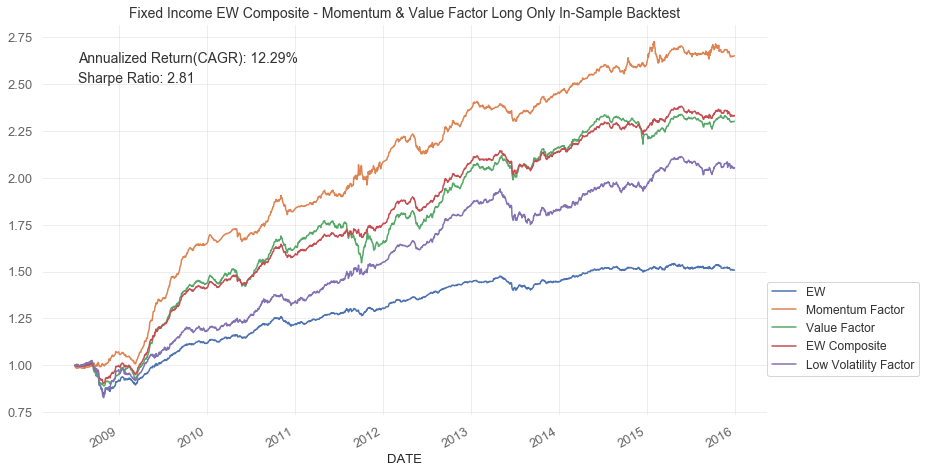

In [23]:
#nbi:hide_in
fif.plot_chart(factors[['EW','Momentum Factor', 'Value Factor', 'EW Composite', 'Low Volatility Factor']], sample_start='2006', sample_end='2015', long_short='No', factor_name = 'EW Composite - Momentum & Value')
plt.legend(loc=(1,0.1));

In [22]:
#nbi:hide_in
erk.summary_stats1(factors,0,252).sort_values('Total Return').T

,UST 1-3Y,UST Int,IG 1-3Y,IG 3-5Y,UST 7-10Y,EW,Crossover,Euro HY,IG 7-10Y,UST Long,US HY,EM HY,Low Volatility Factor,Value Factor,EW Composite,Momentum Factor
Total Return,11.75,25.33,27.23,44.82,47.86,51.02,56.91,57.19,62.06,68.88,72.20,80.19,105.90,130.42,133.74,165.97
Annualized Return,1.53,3.13,3.34,5.18,5.49,5.78,6.33,6.36,6.79,7.42,7.65,8.34,10.36,12.09,12.29,14.28
Annualized Vol,1.24,3.31,1.74,3.31,7.34,3.89,5.03,12.84,6.23,13.86,5.89,7.16,5.94,5.36,4.38,5.12
Skewness,-0.12,0.12,-2.05,-0.62,0.14,-0.72,-2.50,-0.13,-0.41,-0.01,-1.62,-1.59,-0.52,-0.20,-0.24,0.17
Kurtosis,26.66,9.02,40.45,10.67,6.16,9.94,31.50,7.93,8.34,4.04,27.51,24.88,7.46,7.64,6.79,7.07
Cornish-Fisher VaR (5%),0.09,0.30,0.14,0.33,0.69,0.39,0.50,1.25,0.62,1.39,0.55,0.69,0.59,0.50,0.40,0.43
Historic CVaR (5%),0.16,0.46,0.26,0.49,1.01,0.58,0.84,1.89,0.91,1.87,0.98,1.15,0.89,0.77,0.61,0.69
Sharpe Ratio,1.23,0.95,1.92,1.57,0.75,1.49,1.26,0.50,1.09,0.54,1.30,1.17,1.74,2.26,2.81,2.79
Sortino Ratio,25.31,22.01,29.19,31.42,18.23,29.77,18.82,10.67,23.23,13.19,19.82,18.70,35.61,47.68,62.00,62.07
Max Drawdown,-0.96,-4.48,-8.06,-10.82,-10.22,-15.89,-31.28,-44.19,-17.85,-18.40,-32.13,-35.30,-19.40,-12.74,-10.78,-6.12


In [31]:
#nbi:hide_in
spy = yf.download('SPY')['Adj Close']
spy=pd.DataFrame(spy)
spy.columns = ['SPY'];

[*********************100%***********************]  1 of 1 completed


In [32]:
#nbi:hide_in
#qs.reports.html(factors['EW Composite']['2009-05':], spy.pct_change().dropna() , output='Composite.html', title='EW Composite (Momentum, Value, Volatility) Factor Tearsheet')
#import webbrowser
#new = 2
#url = "Composite.html"
#webbrowser.open(url,new=new)

## VIX Switching Strategy

>  Uses VIX level as a percentile of the past lookback period to decide allocation between US Treasuries (Intermediate term, 7-10Y, 20Y+)  and High Yield Bonds (US High Yield, EM High Yield, Euro High Yield, Crossover i.e. BBB-BB).

> For example, if on rebalancing date, current VIX is at 40th percentile of its past 'X' years range, then the model invests 40% of portfolio in US Treasuries (equally weighted in the above mentioned 3 securities/indices) and 60% in High Yield (equally weighted in the above mentioned 4 securities/indices).

> Under 'Compare With' dropdown, Equally Weighted is an equally weighted portfolio of all the above 7 securities/indices.

> Lookback Period is the period to be used (in years) to calculate today's VIX as a percentage of the past 'X' years max VIX.

> Since VIX itself is volatile, VIX Smoothening Period can be used to remove any luck factor. For example a VIX smoothening period of 7 days will mean that after calculating the VIX percentile everyday on a rolling basis, a 7-period moving average is calculated and that value is used for allocation on the rebalancing date.

In [34]:
#Data Collection and Manipulation
#nbi:hide_in
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)
col = indices.columns
duration = indices[['UST Int', 'UST 7-10Y', 'UST Long ']]
high_yield = indices[['US HY', 'EM HY', 'Crossover', 'Euro HY']]

In [35]:
#nbi:hide_in
#qs.reports.html(vix_model['Portfolio'], vix_model.drop(['Portfolio'], axis=1).mean(axis=1), output='VIX_Model.html', title='VIX Allocation Model Tearsheet')
#import webbrowser
#new = 2
#url = "VIX_Model.html"
#webbrowser.open(url,new=new)

### Interactive Paramter Sensitivity Testing for VIX Based Fixed Income Allocation Model 

In [107]:
#nbi:hide_in
import ipywidgets as widgets
from IPython.display import display

In [108]:
#nbi:hide_in
def show_vix_model(lookback_period, smoothening_period, compare_with = 'EW'):
    vix_model = fif.fi_vix_allocator(duration, high_yield, lookback_period, smoothening_period, '2015')
    vix_model['EW'] = vix_model.drop('Portfolio', axis=1).mean(axis=1)
    b = (1+vix_model['Portfolio']).cumprod().plot(figsize=(13,8), fontsize=13, label='VIX Allocation Portfolio')
    plt.title('VIX Allocation Strategy In-Sample Backtest', fontsize=14)
    plt.legend(loc=(1,0.1))
    b.annotate("Annualized Return(CAGR): "+str((erk.annualized_ret(vix_model['Portfolio'], 252)*100).round(2)) +"%", xy=(.05, .90), xycoords='axes fraction', fontsize=14)
    b.annotate("Sharpe Ratio: "+str(erk.sharpe_ratio(vix_model['Portfolio'], 252, 0.0).round(2)), xy=(.05, .85), xycoords='axes fraction', fontsize=14)
    (1+vix_model[compare_with]).cumprod().plot(figsize=(13,8), fontsize=13, label=compare_with)
    plt.legend(loc=(1,0.1))
    return erk.summary_stats1(vix_model,0,252).sort_values('Total Return').T
    

In [109]:
#nbi:hide_in
style = {'description_width': 'initial'}    
interact(show_vix_model,lookback_period = widgets.IntSlider(min=1, max=10, step=1, value=5, description="Lookback Period (Yrs): ",style = {'description_width': '200px'}, layout = {'width': '400px'}),
                                   smoothening_period = widgets.IntSlider(min=1, max=15, step=1, value=7, description="Smoothening Period (Days): ",style = {'description_width': '200px'}, layout = {'width': '400px'}),
                                   compare_with = widgets.Dropdown(options = [('Equally Weighted','EW'), ('US High Yield','US HY'),
                                                                              ('EM High Yield', 'EM HY'), ('US Treasuries 7-10Y', 'UST 7-10Y')], value = 'EW',style=style, description='Compare With: '),
                                   );

interactive(children=(IntSlider(value=5, description='Lookback Period (Yrs): ', layout=Layout(width='400px'), …

In [106]:
#nbi:hide_in
import nbinteract as nbi
nbi.publish('harshshivlani/Fixed-Income-Factor/master', 'Fixed_Income_Factor_Models.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'Fixed_Income_Factor_Models.ipynb'.
Converting notebook...



Successfully converted!

<a href="Fixed_Income_Factor_Models.html" target="_blank" download>Click to download your webpage.</a>

To host your webpage, see the documentation:
<a href="https://www.nbinteract.com/tutorial/tutorial_publishing.html"
        target="_blank">
    https://www.nbinteract.com/tutorial/tutorial_publishing.html
</a>
